# Listening to the audio
This code enables you to listen to a sample sine wave audio.

In [4]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import numpy
import torch
import csv
from sklearn.decomposition import PCA
import itertools

In [5]:
SAMPLE_RATE = 22050

In [6]:
T = 4.0    # seconds
t = np.linspace(0, T, int(T*SAMPLE_RATE), endpoint=False) # time variable
freq = 440
signal = np.sin(2*np.pi*freq*t)
#print len(signal)
ipd.Audio(signal, rate=SAMPLE_RATE)

# Creating spectrograms
Spectrograms provide a 2D feature space to analyze signals in the joint time-frequency domain.

This code generates the spectrogram files for use with the CNN example. It makes files for non-noised data!

In [18]:


f = open('train.csv', 'r')
reader = csv.reader(f)

# Get desired columns and rows from csv, 
# Each row is a sublist inside of lst
# Right now it is taking rows 0 to 70
# and columns 0:10
train = []
for row in itertools.islice(reader, 0, 200):
    train.append(map(float, row[0:88201]))
train=np.array(train)
#Just some re-shaping and dimension finding
#N = 1
#print "N:",N
# train = signal[np.newaxis,:]
print("Train shape",train.shape)
N_train = train.shape[0]
NUM_SAMPLES = train.shape[1]-1

X_train = train[:,:-1]
y_train = train[:,-1]
y_train = y_train.reshape(N_train,1)

print(X_train.shape)
print(y_train)

('Train shape', (200, 88201))
(200, 88200)
[[ 5.]
 [ 0.]
 [ 8.]
 [ 8.]
 [ 5.]
 [ 0.]
 [ 4.]
 [ 9.]
 [ 9.]
 [ 0.]
 [ 9.]
 [ 2.]
 [ 9.]
 [ 0.]
 [ 8.]
 [ 5.]
 [ 0.]
 [ 9.]
 [ 7.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 7.]
 [ 9.]
 [ 5.]
 [ 9.]
 [ 0.]
 [ 7.]
 [ 0.]
 [ 2.]
 [ 9.]
 [ 8.]
 [ 9.]
 [ 5.]
 [ 0.]
 [ 2.]
 [ 5.]
 [ 8.]
 [ 9.]
 [ 0.]
 [ 9.]
 [ 7.]
 [ 0.]
 [ 9.]
 [ 0.]
 [ 3.]
 [ 0.]
 [ 7.]
 [ 7.]
 [ 0.]
 [ 0.]
 [ 5.]
 [ 0.]
 [ 2.]
 [ 9.]
 [ 2.]
 [ 8.]
 [ 7.]
 [ 0.]
 [ 7.]
 [ 2.]
 [ 5.]
 [ 8.]
 [ 0.]
 [ 4.]
 [ 9.]
 [ 2.]
 [ 4.]
 [ 4.]
 [ 0.]
 [ 7.]
 [ 9.]
 [ 0.]
 [ 5.]
 [ 9.]
 [ 2.]
 [ 4.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 7.]
 [ 0.]
 [ 5.]
 [ 9.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 8.]
 [ 4.]
 [ 7.]
 [ 5.]
 [ 7.]
 [ 5.]
 [ 0.]
 [ 8.]
 [ 8.]
 [ 9.]
 [ 0.]
 [ 7.]
 [ 7.]
 [ 0.]
 [ 1.]
 [ 7.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 7.]
 [ 7.]
 [ 7.]
 [ 4.]
 [ 7.]
 [ 0.]
 [ 0.]
 [ 9.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 0.]
 [ 9.]
 [ 7.]
 [ 9.]
 [ 7.]
 [ 9.]
 [ 0.]
 [ 2.]
 [ 9.]
 [ 5.]
 [ 3.]
 [ 7.]
 [ 0.]
 [ 5.]
 [ 0.]
 [ 1.

In [19]:
# JUST SOME FOURIER TRANSFORM PARAMETERS
BINS_OCTAVE = 12*2
N_OCTAVES = 7
NUM_BINS = BINS_OCTAVE * N_OCTAVES

In [20]:
# Given a wav time series, makes a mel spectrogram
# which is a short-time fourier transform with
# frequencies on the mel (log) scale.
def mel_spec(y):
    Q = librosa.cqt(y=y, sr=SAMPLE_RATE, bins_per_octave=BINS_OCTAVE,n_bins=NUM_BINS)
    Q_db = librosa.amplitude_to_db(Q,ref=np.max)
    return Q_db

In [21]:
# This means that the spectrograms are 168 rows (frequencies)
# By 173 columns (time frames)
i=199
song = X_train[i]
print y_train[i]


# print len(song)
# ipd.Audio(song, rate=SAMPLE_RATE)
# print(song)
# test_spec = mel_spec(song)
test_spec = librosa.feature.mfcc(song)
print test_spec
FEATS = test_spec.shape[0]
FRAMES = test_spec.shape[1]
print FEATS
print FRAMES

[ 0.]
[[-154.83768949 -174.93504683 -201.24162963 ..., -196.55342131
  -170.22478087 -130.70205083]
 [ -12.78138714   -9.61882039   -2.71054289 ...,   -6.40679623
   -13.29644504  -24.48403299]
 [  28.58668758   46.25256707   59.80925634 ...,   69.64999412
    49.49869334   25.49617407]
 ..., 
 [  -6.89383957   -6.82928281  -10.35023207 ...,   -6.82363886
    -0.46639969    6.34224753]
 [  10.9985343    13.90943857   14.21944913 ...,   16.31869503
    16.91609156   25.9176393 ]
 [  -3.62580426  -11.68035769  -17.76744085 ...,   -7.55269849
    -5.81644511   -3.605349  ]]
20
173


In [22]:
tmp_train = np.zeros((N_train,FEATS,FRAMES))
for i in range(N_train):
    tmp_train[i,:,:] = librosa.feature.mfcc(X_train[i]) #mel_spec(X_train[i])
#np.save('Data/xtrain_spec', tmp_train)

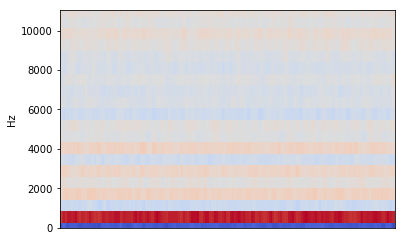

In [25]:
librosa.display.specshow(tmp_train[150], y_axis='hz')

In [35]:
song = X_train[12]
print len(song)
ipd.Audio(song, rate=SAMPLE_RATE)

88200


In [38]:
np.shape(X_train)

(200, 88200)